# Introduction

In this notebook I study the stokeslet, foundamental solution of stokes equation
$$ \nabla \mathbf p +\mu \nabla^2 \mathbf u=\mathbf f$$
The stokeslet gives the flow field $\mathbf u$ in $\mathbf r$ provided the force $\mathbf f(\mathbf r)=\delta(\mathbf r - \mathbf r_0)\mathbf f$ acts on the fluid in $\mathbf r_0$. 
Given the boundary condition: $\mathbf u(\infty)=0$, the stokeslet is the linear operator:
$$ \frac{4 \pi}{\mu}\frac{1}{\lVert \mathbf r\rVert }\left[ \mathbb I + \mathbf r \mathbf r^T\right]$$
where $\mathbf r$ is the vector between $r_0$ and the point where we compute the fluid.

In this notebook I'm interested in:
1. Visualize the flux generated by a single delta point force in $\mathbf r_0=(0,0)$
   This can be thought as the far-field flux generated by a small spherical colloidal particle, moving with constant velocity $\gamma^{-1}\mathbf f$. 
2. Visualize and compare the flux generated by a rod. A couple of things now come to my mind:
    1. Visualize the flow generated by a line of beads that "simulate" the rod. This is the usual approach to compute the drag coeficient as in slender body theory, and to design simulations with interacting filaments.
    2. I want to use a tensorial drag to compute the force acting on the flow. It is known from Slender body theory (see lightnill's book) that the force of a rod moving in a fluid can be decomposed into 2 drag coefficients in the "tangent" and "normal" direction: 
    $$\mathbf f=\left(\gamma_\perp \hat n \hat n^T + \gamma_\parallel \hat t \hat t^T\right) \mathbf v$$
    where $\gamma_\parallel$ and $\gamma_\perp$ are defined by the shape of the body.
3. Using the 2.2 I want to use the "Blake tensor". That is the fondamental solution of stokes equation when the fluid is confined in a half-space, with no-slip BC at the wall

## Python definitions

In [6]:
import numpy as np
import pylab as pl
import seaborn as sns
sns.set_style("white")
%matplotlib inline

In [2]:
x,X,y,Y=-5,5,-5,5 #our space
dx,dy=.5,.5       #discretisation
mX,mY=np.meshgrid(np.arange(x,X,dx),np.arange(y,Y,dy))

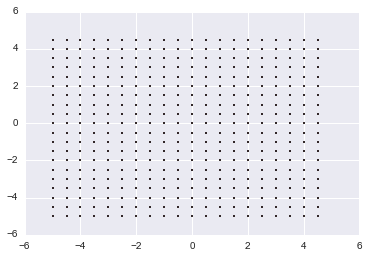

In [3]:
pl.scatter(mX,mY,s=1,lw=1,c='r')

# Flow of a point force

In [4]:
r0=np.array([0.05,0.05])            # position of the force
f=np.array([0,1])             # direction of the force


def stokeslet(f,r0,mX,mY):
    Id=np.array([[1,0],[0,1]])
    r=np.array([mX-r0[0],mY-r0[1]])

    Idf=np.dot(Id,f)
    
    rTf=(r*f[:,np.newaxis,np.newaxis]).sum(axis=0)
    rrTf=(r*rTf[np.newaxis,])
    modr=(r[0]**2+r[1]**2+.01)**.5
    
    u,v=Idf[:,np.newaxis,np.newaxis]/modr[np.newaxis]+rrTf/modr**3.
    return u,v



## Monopole

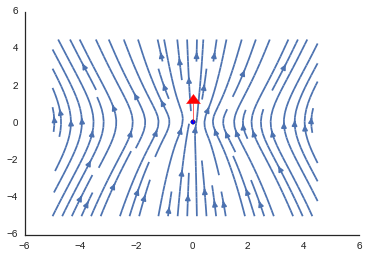

In [9]:
u,v=stokeslet(f,r0,mX,mY)
pl.streamplot(mX,mY,u,v)
pl.scatter(r0[0],r0[1])
pl.arrow(r0[0],r0[1],f[0],f[1],head_width=0.5, head_length=0.5, fc='r', ec='r')
sns.despine()
pl.savefig("monopole.pdf",bbox_inches=0)

## Dipole

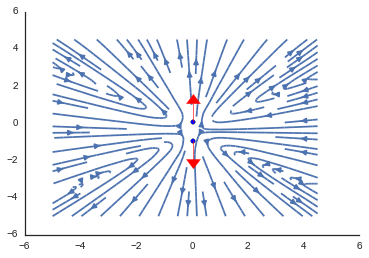

In [10]:


u,v=stokeslet(f,r0,mX,mY)

f1=-f
r1=r0+np.array((0,-1))

u1,v1=stokeslet(f1,r1,mX,mY)
#superimposition principle because of linearity of Stokes eq
u+=u1
v+=v1
pl.streamplot(mX,mY,u,v)

#draw force arrows
def draw_force(r,f):
 pl.scatter(r[0],r[1])
 pl.arrow(r[0],r[1],f[0],f[1],head_width=0.5, head_length=0.5, fc='r', ec='r')
draw_force(r0,f)
draw_force(r1,f1)
sns.despine()
pl.savefig("dipole.pdf",bbox_inches=0)

## 2 parallel dipoles - as 2 parallel microswimmers

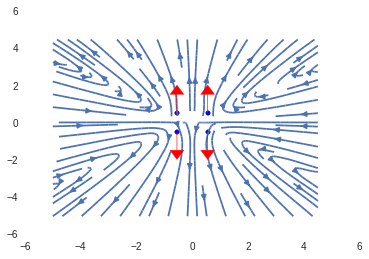

In [16]:
def dipole(f0,r0,mX,mY,dx):
    
    r1=r0+np.array(dx)
    f1=-f0
    u,v=stokeslet(f0,r0,mX,mY)
    u1,v1=stokeslet(f1,r1,mX,mY)
    
    u+=u1
    v+=v1
    return u,v,f0,f1,r0,r1

#dipole @ left
rl=np.array([-0.55,0.55])
fl=np.array((0,1))
ul,vl,f0,f1,r0,r1=dipole(fl,rl,mX,mY,(0,-1))
draw_force(r0,f)
draw_force(r1,f1)
#dipole @ right
rr=np.array([+.55,.55])
fr=np.array((0,1))
ur,vr,f0,f1,r0,r1=dipole(fr,rr,mX,mY,(0,-1))
draw_force(r0,f)
draw_force(r1,f1)

pl.streamplot(mX,mY,ur+ul,vl+vr)

*Questions*
1. what's the force between the 2 dipoles?
2. what's the force between the 2 monopoles of a single dipole?

# Rod in a fluid

## Method 1: line of stokeslets

In the following I assume that the rod velocity direction is given by the force and that the force is equal at each rod

<matplotlib.contour.QuadContourSet instance at 0x2aaac40eccf8>

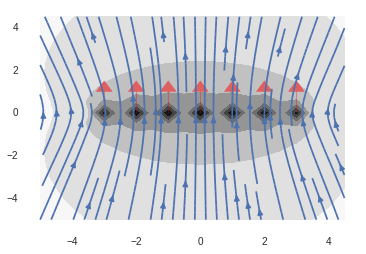

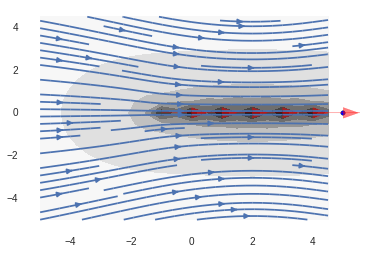

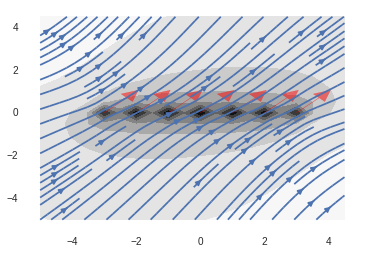

In [21]:
def nlet(f0,r0,mX,mY,dx,n):
    dx=np.array(dx)
    f=[]
    r=[]
    u=np.zeros(mX.shape)
    v=np.zeros(mY.shape)
    for j in xrange(int(n)):
        _r=r0+j*dx
        _f=f0
        _u,_v=stokeslet(_f,_r,mX,mY)
        u+=_u
        v+=_v
        f.append(_f)
        r.append(_r)
    return u,v,f,r

#draw force arrows
def draw_force(r,f,c='r'):
 pl.scatter(r[0],r[1])
 pl.arrow(r[0],r[1],f[0],f[1],head_width=0.5, head_length=0.5, fc=c, ec=c,alpha=.5)

L=6
dx=1
n=L/dx+1

r=np.array([-3,0])
f=np.array((0,1))
u,v,f,r=nlet(f,r,mX,mY,(dx,0),n)
for _f,_r in zip(f,r):
    draw_force(_r,_f)
pl.streamplot(mX,mY,u,v,zorder=10)
pl.contourf(mX,mY,(u**2+v**2)**.5)

pl.figure()
r=np.array([-1,0])
f=np.array((1,0))
u,v,f,r=nlet(f,r,mX,mY,(dx,0),n)
for _f,_r in zip(f,r):
    draw_force(_r,_f)
pl.streamplot(mX,mY,u,v,zorder=10)
pl.contourf(mX,mY,(u**2+v**2)**.5)

pl.figure()
r=np.array([-3,0])
f=np.array((1,1))/2**.5
u,v,f,r=nlet(f,r,mX,mY,(dx,0),n)
for _f,_r in zip(f,r):
    draw_force(_r,_f)
pl.streamplot(mX,mY,u,v,zorder=10)
pl.contourf(mX,mY,(u**2+v**2)**.5)

##  Method 2: anysotropic drag coeeficient

A rod is moving in the flud with velocity $\mathbf v$. Due to its shape the drag coeffienct is not isotropic and force needed to push the rod at the given velocity is:
$$\mathbf f=\left(\gamma_\perp \hat n \hat n^T + \gamma_\parallel \hat t \hat t^T\right) \mathbf v$$
$$\mathbf f=\left(\gamma_\perp (1-\hat t \hat t^T) + \gamma_\parallel \hat t \hat t^T\right) \mathbf v$$
where $\hat n$ and $\hat t$ are the normal and tangent direction. For simplicity, I initially assume that the rod is parallel to the $\hat x$ axis. It is clear that force and velocity are not parallel as they were in the case of spherical beads.
The drag coefficients depends on the shape, I do not remember the function now.

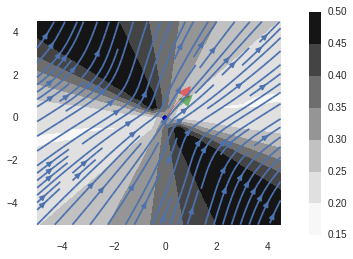

In [22]:
def draw_force(r,f,c='r'):
 pl.scatter(r[0],r[1])
 pl.arrow(r[0],r[1],f[0],f[1],head_width=0.5, head_length=0.5, fc=c, ec=c,alpha=.5)
    
v0=1
a=np.pi/4.
v=v0*np.array([np.cos(a),np.sin(a)])

n=np.array([0,1])
t=np.array([1,0])

#Cs is the shape coefficient
Cs=1.5
gamma_para=1
gamma_perp=Cs*gamma_para
f=gamma_perp*n*np.dot(n,v)+gamma_para*t*np.dot(t,v)
r0=np.array([0,0])
#for comparisons: same modulo btw force and velocity
#f/=sum(f**2)**.5
#v/=sum(v**2)**.5


ux,uy=stokeslet(f,r0,mX,mY)
pl.streamplot(mX,mY,ux,uy,zorder=10)
_ux,_uy=stokeslet(v,r0,mX,mY)
#pl.streamplot(mX,mY,_ux,_uy,linewidth=.5)
#pl.streamplot(mX,mY,ux-_ux,uy-_uy)
V=((ux-_ux)**2+(uy-_uy)**2)**.5
U=(.25*(ux+_ux)**2+.25*(uy+_uy)**2)**.5

pl.contourf(mX,mY,V/U)

pl.colorbar()
draw_force(r0,f)
draw_force(r0,v,'g')

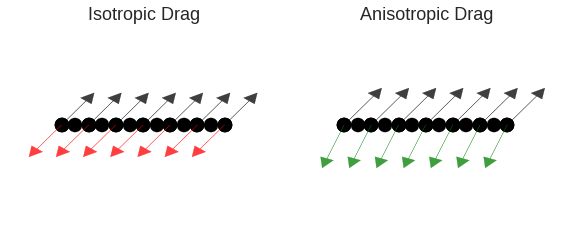

In [9]:

def nlet(f0,r0,mX,mY,dx,n,Cs=1.):
    dx=np.array(dx)
    f=[]
    r=[]
    u=np.zeros(mX.shape)
    v=np.zeros(mY.shape)
    tt=np.array([1,0])
    nn=np.array([0,1])

    #Cs is the shape coefficient
    
    gamma_para=1
    gamma_perp=Cs*gamma_para
    ff=gamma_perp*nn*np.dot(nn,f0)+gamma_para*tt*np.dot(tt,f0)
    ff/=(ff**2.).sum()**.5
    for j in xrange(int(n)):
        _r=r0+j*dx
        _f=f0
        #_u,_v=stokeslet(_f,_r,mX,mY)
        #u+=_u
        #v+=_v
        f.append(-ff)
        r.append(_r)
    return u,v,f,r

#draw force arrows
def draw_force(r,f,ax,c='r'):
 ax.scatter(r[0],r[1],s=200,c='k',)
 ax.arrow(r[0],r[1],f[0],f[1],head_width=0.5, head_length=0.5, fc=c, ec=c,alpha=.75)

L=6
dx=.5
n=L/dx+1

fig,(a,b)=pl.subplots(1,2,figsize=np.asarray((12,5))/1.5)

r=np.array([-3,0])
fin=np.array((.75,1))
fin/=(fin**2).sum()**.5
u,v,f,r=nlet(fin,r,mX,mY,(dx,0),n)
for _f,_r in zip(f,r):
    draw_force(_r,_f*0,a)
for _f,_r in zip(f,r)[::2]:
    draw_force(_r,_f*1.5,a)
for _r in r[::2]:
    draw_force(_r,fin*1.5,a,c='k')
#a.streamplot(mX,mY,u,v,linewidth=.5,color='k',density=.5)
#a.contourf(mX,mY,(u**2+v**2)**.5,zorder=-10)

DragRatio=1.8
r=np.array([-3,0])
u,v,f,r=nlet(fin,r,mX,mY,(dx,0),n,Cs=2.)
for _f,_r in zip(f,r):
    draw_force(_r,_f*0,b)
for _f,_r in zip(f,r)[::2]:
    draw_force(_r,_f*DragRatio,b,c='g')
for _r in r[::2]:
    draw_force(_r,fin*DragRatio,b,c='k')
#b.streamplot(mX,mY,u,v,linewidth=.5,color='k',density=.5)
#b.contourf(mX,mY,(u**2+v**2)**.5,zorder=-10)

a.xaxis.set_ticks([])
a.yaxis.set_ticks([])
b.xaxis.set_ticks([])
b.yaxis.set_ticks([])

a.set_xlim(x,X)
a.set_ylim(y,Y)

b.set_xlim(x,X)
b.set_ylim(y,Y)


a.set_title("Isotropic Drag",fontsize=18)
b.set_title("Anisotropic Drag",fontsize=18)

fig.tight_layout()
fig.savefig("res_forc.pdf",bbox_inches="tight")